In [1]:
!pip install --upgrade tensorflow tensorflow_hub

  Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [3]:
df = pd.read_csv('wine-reviews.csv',  usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

In [4]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [5]:
df = df.dropna(subset=['description', 'points'])

In [6]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


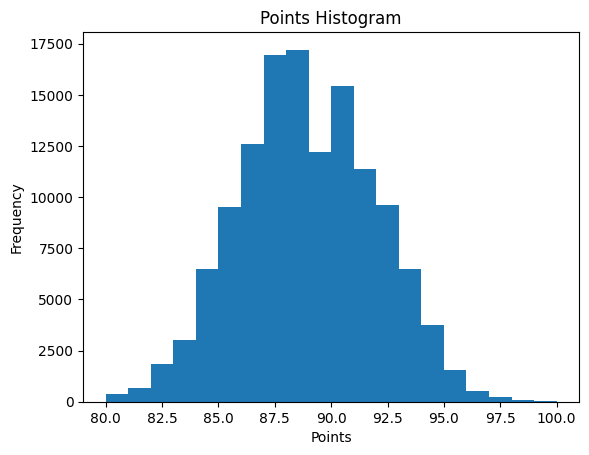

In [7]:
plt.hist(df.points, bins=20)
plt.title("Points Histogram")
plt.xlabel("Points")
plt.ylabel("Frequency")
plt.show()

In [8]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "points", "label"]]


In [9]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [10]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [11]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [29]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding,
                           dtype=tf.string, trainable=True)

In [30]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.4242579 ,  0.06181573,  0.00722517, ..., -0.1897387 ,
        -0.29040822, -0.06199634],
       [ 0.27354634, -0.23787093,  0.06401271, ..., -0.04218096,
        -0.20839813, -0.11709235],
       [ 0.5790061 ,  0.05748893,  0.13366558, ..., -0.21865858,
        -0.22378072, -0.09568848],
       ...,
       [ 0.44648692, -0.5189432 , -0.10669447, ...,  0.02046075,
        -0.17377566, -0.09436284],
       [ 0.2602371 , -0.13120544,  0.09100196, ..., -0.16539799,
        -0.19987215,  0.07312002],
       [ 0.14581206, -0.60884947, -0.11623769, ...,  0.10075233,
        -0.03761996,  0.06554843]], dtype=float32)>

In [36]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Lambda(lambda x: hub_layer(x)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [33]:
model.evaluate(train_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6230 - loss: 0.6761


[0.6762568950653076, 0.6223359107971191]

In [34]:
model.evaluate(valid_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6193 - loss: 0.6763


[0.6755504012107849, 0.6248365044593811]

In [38]:
history = model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6230 - loss: 0.6692 - val_accuracy: 0.6400 - val_loss: 0.6293
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6618 - loss: 0.6163 - val_accuracy: 0.6914 - val_loss: 0.5860
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6951 - loss: 0.5837 - val_accuracy: 0.6999 - val_loss: 0.5713
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7026 - loss: 0.5721 - val_accuracy: 0.7019 - val_loss: 0.5664
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7048 - loss: 0.5680 - val_accuracy: 0.7053 - val_loss: 0.5644
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7069 - loss: 0.5666 - val_accuracy: 0.7059 - val_loss: 0.5642
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7091 - loss: 0.5635 - val_accuracy: 0.7080 - val_loss: 0.5630
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7083 - loss: 0.5636 - val_accu

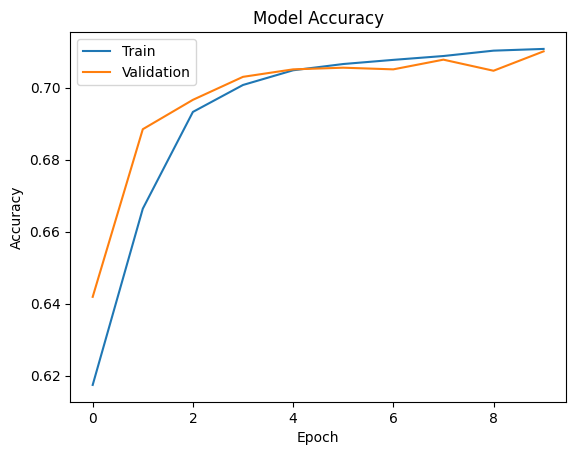

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

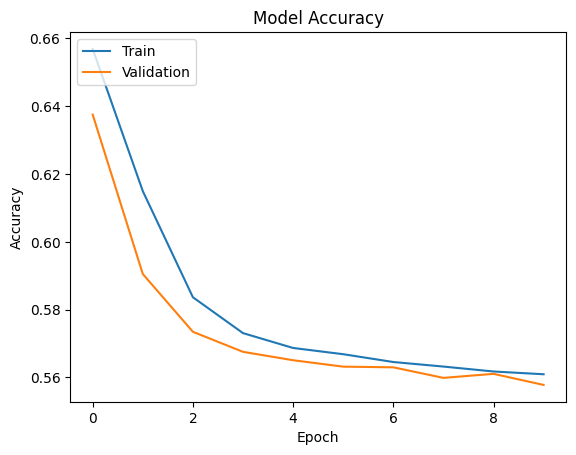

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [39]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7076 - loss: 0.5605


[0.5662102103233337, 0.702800452709198]

#LSTM

In [40]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [41]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [42]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [43]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [44]:
model.evaluate(train_data)
model.evaluate(valid_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 0.4750 - loss: 0.6933
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.4783 - loss: 0.6933


[0.6933509111404419, 0.47318610548973083]

In [45]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 396ms/step - accuracy: 0.6537 - loss: 0.6176 - val_accuracy: 0.8260 - val_loss: 0.3792
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 391ms/step - accuracy: 0.8328 - loss: 0.3794 - val_accuracy: 0.8352 - val_loss: 0.3558
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 390ms/step - accuracy: 0.8436 - loss: 0.3544 - val_accuracy: 0.8411 - val_loss: 0.3457
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 393ms/step - accuracy: 0.8483 - loss: 0.3429 - val_accuracy: 0.8388 - val_loss: 0.3498
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 411ms/step - accuracy: 0.8516 - loss: 0.3374 - val_accuracy: 0.8414 - val_loss: 0.3458


In [46]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.8413 - loss: 0.3464


[0.3484479486942291, 0.8394368290901184]